### Import all libraries required

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn import svm

### Read data from the csv

In [2]:
demen_data = pd.read_csv('final_oasis_dementia.csv')

### Drop irrelevant columns such as Visit, which won't make any contribution for training the data

In [3]:
demen_data = demen_data.drop(columns=['Visit'])

In [4]:
print(demen_data.head())
print(demen_data.iloc[:,1].max())

         Group  MR.Delay  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF
0  Nondemented         0   87    14    2    27  0.0  1987  0.696  0.883
1  Nondemented       457   88    14    2    30  0.0  2004  0.681  0.876
2     Demented         0   75    12    0    23  0.5  1678  0.736  1.046
3     Demented       560   76    12    0    28  0.5  1738  0.713  1.010
4     Demented      1895   80    12    0    22  0.5  1698  0.701  1.034
2517


### Convert the string data classes to numeric 0 and 1

In [5]:
demen_data.Group = demen_data.Group.replace('Nondemented', 0)
demen_data.Group = demen_data.Group.replace('Demented',1)

### Normalize the data for appropriate parameter tuning without any skewed entries

In [6]:
def normalize_data(data):
    tmp = pd.DataFrame()
    for i in range(data.shape[1]):
        max_val = data.iloc[:,i].max()
        data.iloc[:,i] = data.iloc[:,i].divide(max_val).to_frame()
    return data

In [7]:
data = normalize_data(demen_data.iloc[:,1:10])
print(data.head())

   MR.Delay       Age      EDUC  SES      MMSE   CDR      eTIV      nWBV  \
0  0.000000  0.887755  0.608696  0.4  0.900000  0.00  0.991517  0.831541   
1  0.181565  0.897959  0.608696  0.4  1.000000  0.00  1.000000  0.813620   
2  0.000000  0.765306  0.521739  0.0  0.766667  0.25  0.837325  0.879331   
3  0.222487  0.775510  0.521739  0.0  0.933333  0.25  0.867265  0.851852   
4  0.752880  0.816327  0.521739  0.0  0.733333  0.25  0.847305  0.837515   

        ASF  
0  0.556396  
1  0.551985  
2  0.659105  
3  0.636421  
4  0.651544  


### Randomly divide the dataset into partitions 80% train and 20% test, convert the output i.e. actual test values to a numpy array for iterations

In [37]:
msk = np.random.rand(len(demen_data)) < 0.8
train = data[msk]
labels = demen_data.Group[msk]
test = data[~msk]
output = np.array(demen_data.Group[~msk])

### Train the model using svm.SVC which is a Support Vector Machine Classifier

In [38]:
model = svm.SVC(probability=True)
model.fit(train, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Make predictions on the test data

In [39]:
pred = model.predict(test)

### Count the number of correctly classified entries to get the accuracy of the model

In [40]:
count = 0
for i in range(len(pred)):
    if pred[i] == output[i]:
        count += 1
print(count, len(pred))
acc = float(count)/float(len(pred))
print("Accuracy :", acc)

70 71
Accuracy : 0.9859154929577465


In [41]:
print(pred)

[0 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 0 0 0
 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1]


### To plot the ROC curve as in the paper, we calculate the true positives, true negatives, false positives and false negatives

In [42]:
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for i in range(len(pred)):
    if pred[i] == 1 and output[i] == 1:
        true_pos += 1
    elif pred[i] == 1 and output[i] == 0:
        false_pos += 1
    elif pred[i] == 0 and output[i] == 1:
        false_neg += 1
    elif pred[i] == 0 and output[i] == 0:
        true_neg += 1

In [43]:
print(true_neg,true_pos,false_neg,false_pos, true_neg+true_pos+false_neg+false_pos, len(pred) )

39 31 0 1 71 71


### True Positive Rate is calculated as TPR = TP/ (TP + FN) and False Positive Rate as FPR = FP/(FP + TN)

In [44]:
tpr = float(true_pos)/(float(true_pos) + float(false_neg))
fpr = float(false_pos)/(float(false_pos) + float(true_neg))
print(tpr,fpr)

1.0 0.025


### Making the plot consistent, we convert the TPR and FPR in the proper format and draw the plot as shown below with the AUC accuracy calculated from the TPR and FPR

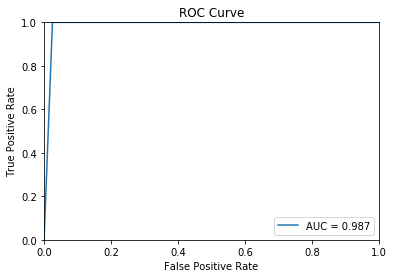

In [59]:
tpr_arr = [0.0, tpr, 1.0]
fpr_arr = [0.0, fpr, 1.0]
plt.title('ROC Curve')
plt.plot(fpr_arr, tpr_arr, label = 'AUC = %0.3f' % auc(fpr_arr, tpr_arr))
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()